<h1 style="font-size: 80px; color: blue"> 
Olivia Finder - Usage
</h1>


This notebook consists in the use of the **Olivia** library with the different data obtained through **Olivia Finder**

-    How to generate a data set using Olivia-Finder
-    How we can generate an Olivia model from these data.
-    How can we use the Olivia model

# **0 - Previous requirements**

## Setup venv and install requirements

In [1]:
# Olivia requirements
# %pip install -r ../olivia/requirements.txt

In [2]:
# Olivia Finder requirements
# %pip install -r requirements.txt

If you use a virtual environment, it is necessary to configure it as selected in the Jupyter kernel


## Setup library path

Make sure to run this cell to have the **olivia** and **olivia-finder** library at PATH

In [1]:
# Append the path to the olivia_finder package
import sys
sys.path.append('../../olivia/')
sys.path.append('../../olivia_finder/')

## Setup configuration

It is necessary to initialize the configuration, the most comfortable and global way to do so is through an environment variable

In [2]:
# Add the environment variable OLIVIA_FINDER_CONFIG_FILE_PATH

import os
os.environ['OLIVIA_FINDER_CONFIG_FILE_PATH'] = "../../olivia_finder/config.ini"

# **1 - Build the dataset**

In this section we will use Olivia Finder to build the dataset of the network that we want to analyze

In [3]:
from olivia_finder.package_manager import PackageManager

## Using data from persistence

### Olivia finder persistence objects

We can use persistence objects generated with Olivia-Finder previously and from them generate a Networkx graph with which to feed Olivia

In [7]:
# Load bioconductor olivia-finder persistence package manager object
bioconductor_pm_loaded = PackageManager.load_from_persistence("../results/package_managers/bioconductor_scraper.olvpm")

# Get the networkx graph object
bioconductor_G_loaded = bioconductor_pm_loaded.get_network()
print(f'Nodes: {len(bioconductor_G_loaded.nodes)}')
print(f'Edges: {len(bioconductor_G_loaded.edges)}')

Nodes: 3509
Edges: 28320


### Csv files

Load the bioconductor network using a CSV file on a package manager object

In [8]:
bioconductor_pm_csv =  PackageManager.load_from_csv(
    "../results/csv_datasets/bioconductor/bioconductor_adjlist_scraping.csv",
    default_format=True
)
bioconductor_G_csv = bioconductor_pm_csv.get_network()
print(f'Nodes: {len(bioconductor_G_csv.nodes)}')
print(f'Edges: {len(bioconductor_G_csv.edges)}')

Nodes: 3509
Edges: 28320


In [23]:
# Degree Distribution with Axes in Logarithmic Scale

import matplotlib.pyplot as plt
import networkx as nx

def plot_degree_distribution(G, title):
    '''
    Plot the degree distribution of a networkx graph
    '''

    degrees = [G.degree(node) for node in G]
    plt.figure(figsize=(5,5))
    plt.hist(degrees, bins=100)
    plt.title(title)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

def draw_networkx_graph(G, layout='circular'):
    '''
    Draw a networkx graph
    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
    }
    plt.figure(figsize=(12,9))
    pos = layouts[layout](G)
    node_size = [G.in_degree(node) * 80 for node in G]
    node_color = [G.in_degree(node) for node in G]
    edge_color = [G.in_degree(edge[0]) for edge in G.edges]
    width = 1
    nx.draw_networkx(G, pos=pos, node_size=node_size, node_color=node_color, alpha=0.7, with_labels=True, edge_color=edge_color, width=width)


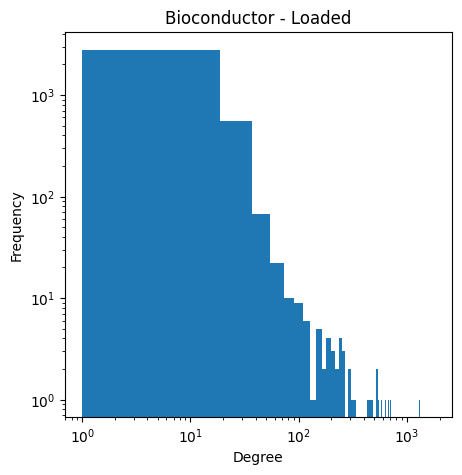

In [24]:
plot_degree_distribution(bioconductor_G_loaded, "Bioconductor - Loaded")

Nodes: 39
Edges: 95


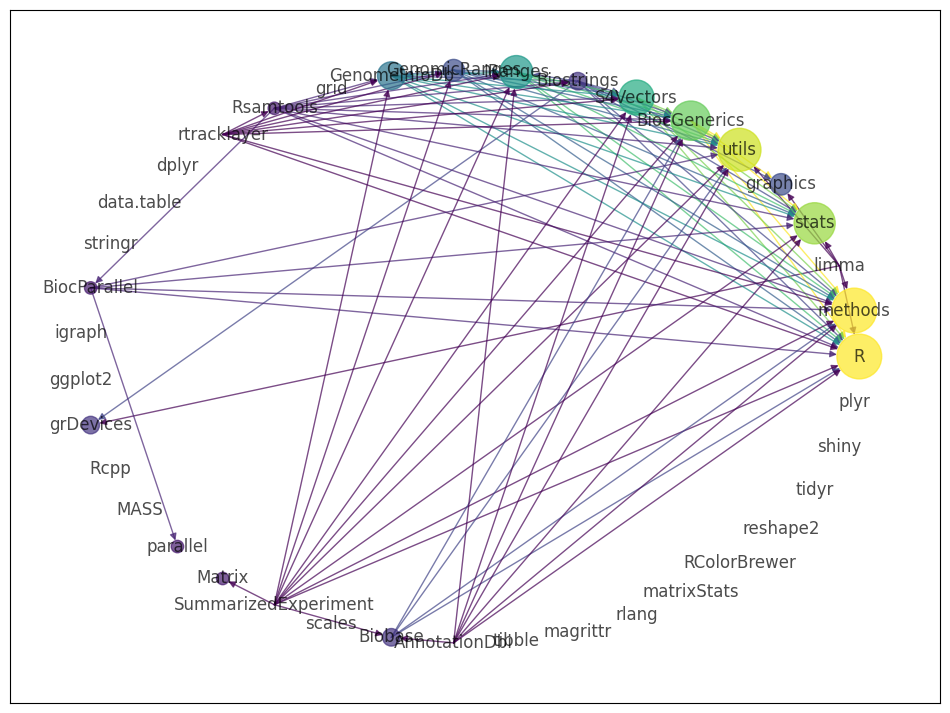

In [25]:
# Drop nodes with in_degree < 20
bioconductor_G_csv_filtered = bioconductor_G_csv.copy()
for node in bioconductor_G_csv.nodes:
    if bioconductor_G_csv.in_degree(node) < 150:
        bioconductor_G_csv_filtered.remove_node(node)

print(f'Nodes: {len(bioconductor_G_csv_filtered.nodes)}')
print(f'Edges: {len(bioconductor_G_csv_filtered.edges)}')

# Draw the graph
draw_networkx_graph(bioconductor_G_csv_filtered, layout='shell')


## Build custom network

**Instantance the Package Manager object according to our needs**

#### Scraping data

Build the network for the "retire" package

In [26]:
from olivia_finder.data_source.repository_scrapers.npm import NpmScraper

npm_pm = PackageManager(
    data_sources=[NpmScraper()]
)
retire_G  = npm_pm.get_dependency_network(
    package_name="retire", 
    deep_level=3, 
    generate=True
)
del npm_pm
print(f'Nodes: {len(retire_G.nodes)}')
print(f'Edges: {len(retire_G.edges)}')

Nodes: 999
Edges: 2046


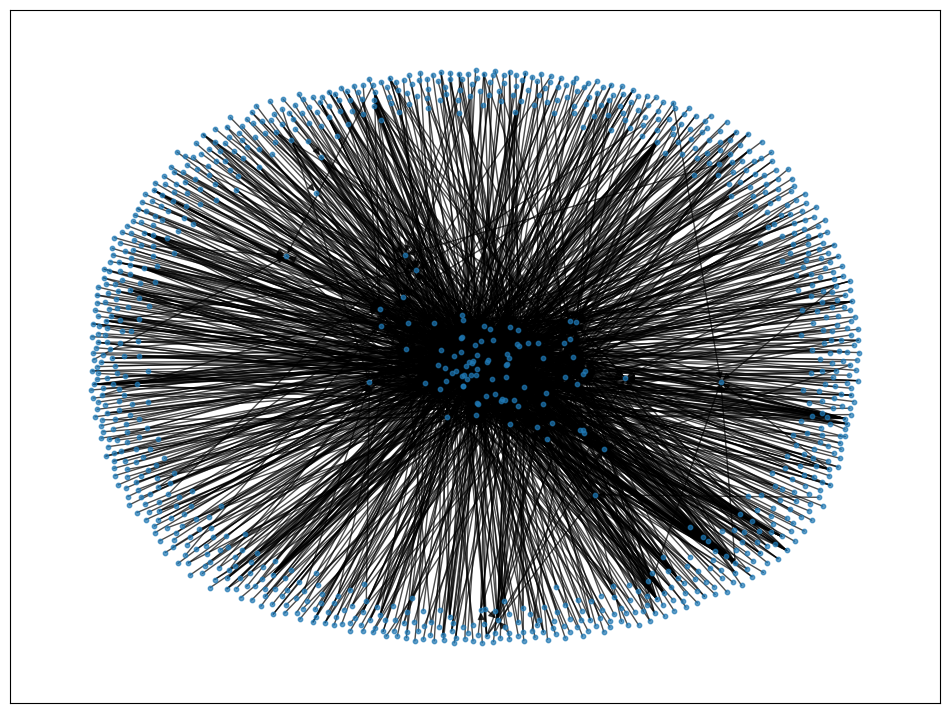

In [38]:

# Draw the graph using the spring layout
plt.figure(figsize=(12,9))
nx.draw_networkx(retire_G.reverse(), pos=nx.spring_layout(retire_G), node_size=10, alpha=0.7, with_labels=False)
plt.show()

Build the retwork for "GOstats" combining 2 differents data source

In [13]:
from olivia_finder.data_source.repository_scrapers.cran import CranScraper
from olivia_finder.data_source.repository_scrapers.bioconductor import BioconductorScraper

bioconductor_pm_multiple = PackageManager(
    data_sources=[
        BioconductorScraper(),
        CranScraper(),
    ]
)
GOstats_G = bioconductor_pm_multiple.get_dependency_network(
    package_name="GOstats",
    deep_level=3,
    generate=True
)
del bioconductor_pm_multiple
print(f'Nodes: {len(GOstats_G.nodes)}')
print(f'Edges: {len(GOstats_G.edges)}')

Error while obtaining the name of the package: 'NoneType' object has no attribute 'text'


Nodes: 39
Edges: 131


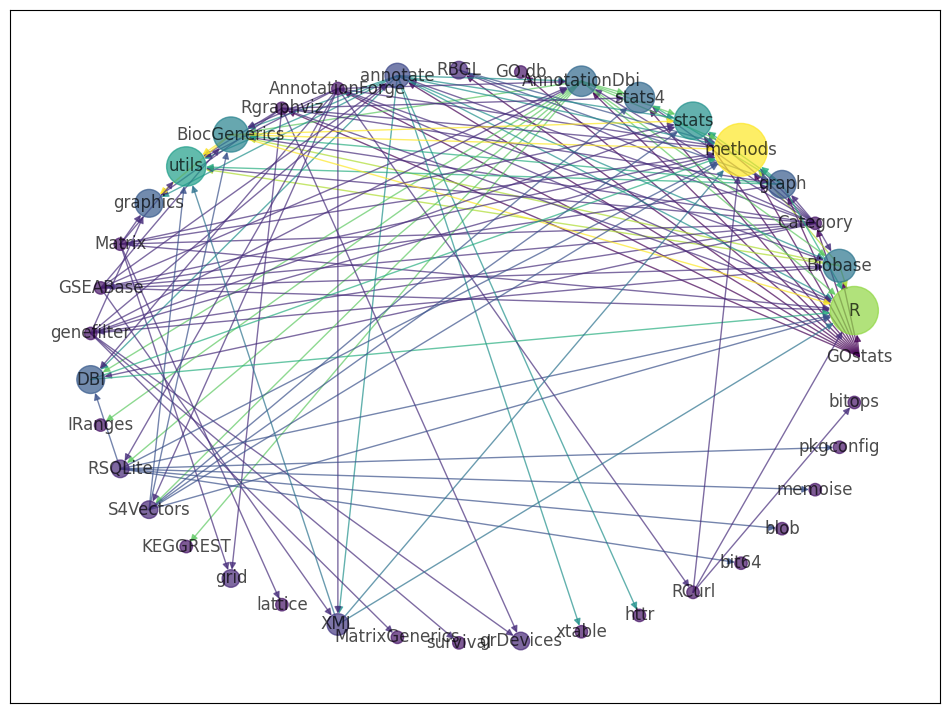

In [14]:
# Draw the graph
draw_networkx_graph(GOstats_G)

# **2 - Build olivia model**

In [15]:
from olivia.model import OliviaNetwork

### Using full network data from scraping

In [16]:
bioconductor_model = OliviaNetwork()
bioconductor_model.build_model(bioconductor_G_loaded)

Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done


### Using single package networks

In [17]:
retire_network_model = OliviaNetwork()
retire_network_model.build_model(retire_G)

Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done


In [18]:
gostats_network_model = OliviaNetwork()
gostats_network_model.build_model(GOstats_G)

Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done


# **3 - Olivia metrics**

In [19]:
from olivia.networkmetrics import attack_vulnerability, failure_vulnerability

In [20]:
bioconductor_atack_vulnerability = attack_vulnerability(bioconductor_model)
bioconductor_failure_vulnerability = failure_vulnerability(bioconductor_model)

Computing Reach
     Processing node: 3K      
Reach retrieved from metrics cache


In [21]:
retire_atack_vulnerability = attack_vulnerability(retire_network_model)
retire_failure_vulnerability = failure_vulnerability(retire_network_model)

Computing Reach
     Processing node: 0K      
Reach retrieved from metrics cache


In [22]:
gostats_atack_vulnerability = attack_vulnerability(gostats_network_model)
gostats_failure_vulnerability = failure_vulnerability(gostats_network_model)

Computing Reach
     Processing node: 0K      
Reach retrieved from metrics cache


In [23]:
print(f'bioconductor_atack_vulnerability: {bioconductor_atack_vulnerability}')
print(f'bioconductor_failure_vulnerability: {bioconductor_failure_vulnerability}')
print()
print(f'retire_atack_vulnerability: {retire_atack_vulnerability}')
print(f'retire_failure_vulnerability: {retire_failure_vulnerability}')
print()
print(f'gostats_atack_vulnerability: {gostats_atack_vulnerability}')
print(f'gostats_failure_vulnerability: {gostats_failure_vulnerability}')

bioconductor_atack_vulnerability: 2109
bioconductor_failure_vulnerability: 24.817326873753206

retire_atack_vulnerability: 19
retire_failure_vulnerability: 3.736842105263158

gostats_atack_vulnerability: 39
gostats_failure_vulnerability: 7.205128205128205
